# Creating a Video for Training Each Style

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict

def get_structured_data(data):
    key_value_tups = (OrderedDict(element.split(' = ') for element in line.split('; ')) for line in data)
    return pd.DataFrame(key_value_tups)

test_dirname = 'test_dir_fractal_flower_all/' ### hard coded


with open(test_dirname + 'runtime_fractal_flower_all.txt') as f: ## hard coded file name
    data = f.read().splitlines()
    useful_data = [line for line in data if 'Current Time' in line]
    structured_data = get_structured_data(useful_data)
    structured_data[['Epoch', 'Iteration']] = structured_data[['Epoch', 'Iteration']].astype('int')
    structured_data[['Loss', 'Time Elapsed']] = structured_data[['Loss', 'Time Elapsed']].astype('float32')
    # structured_data.set_index(structured_data.index * 50, inplace=True) ### hard coded to 50 iterations
    structured_data.set_index(range(len(structured_data)) * structured_data['Iteration'][0], inplace=True) #### seems to work

In [2]:
%%time
import imageio
from datetime import datetime, timedelta

seconds_between_frames = 30 # represents seconds of time for training
max_length_in_seconds = 60 * 60 * 8 ## hard coded to represent maximum length of training time
output_filename = test_dirname + 'movie.mp4'

image_filenames = []
next_frame_timestamp = None
for row_id, row in structured_data.iterrows():
    if row_id == 0:
        start_time = (datetime.strptime(row['Current Time'], "%Y %B %d, %H:%M:%S") -
                      timedelta(seconds=int(row['Time Elapsed'])))
        next_frame_timestamp = start_time
        while next_frame_timestamp < datetime.strptime(row['Current Time'], "%Y %B %d, %H:%M:%S"):
            image_filenames.append("{}{}_{}.png".format(test_dirname, row['Epoch'], row['Iteration']))
            next_frame_timestamp += timedelta(seconds=seconds_between_frames)
            
    else:
        while next_frame_timestamp < datetime.strptime(row['Current Time'], "%Y %B %d, %H:%M:%S"):
            image_filenames.append("{}{}_{}.png".format(test_dirname, row['Epoch'], row['Iteration']))
            next_frame_timestamp += timedelta(seconds=seconds_between_frames)        
        
image_sequence = []
for filename in image_filenames[:max_length_in_seconds // seconds_between_frames]:
    image_sequence.append(imageio.imread(filename))
imageio.mimsave(output_filename, image_sequence, fps=48) ### fps hard coded

CPU times: user 26.3 s, sys: 1.11 s, total: 27.4 s
Wall time: 31.6 s


# Stitch all Videos Together

In [1]:
import moviepy.editor as mpe
import numpy as np
from glob import glob

movies = []
# for movie_filename in sorted(glob('test_dir*/movie.mp4*')):
for movie_filename in [
    'test_dir_fractal_flower/movie.mp4', 'test_dir_fractal_flower_all/movie.mp4',
    'test_dir_autumn/movie.mp4', 'test_dir_fractal/movie.mp4', 'test_dir_gatsby/movie.mp4',
    'test_dir_starry_night/movie.mp4']:
    movies.append(mpe.VideoFileClip(movie_filename).margin(10)) ### border margin hard coded

all_clips = np.array(movies).reshape(2, 3)
final_clip = mpe.clips_array(all_clips)
final_clip.write_videofile('combined_movie.mp4')

[MoviePy] >>>> Building video combined_movie.mp4
[MoviePy] Writing video combined_movie.mp4


100%|█████████▉| 960/961 [02:09<00:00,  7.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: combined_movie.mp4 



# Plot Metrics

(0, 26000)

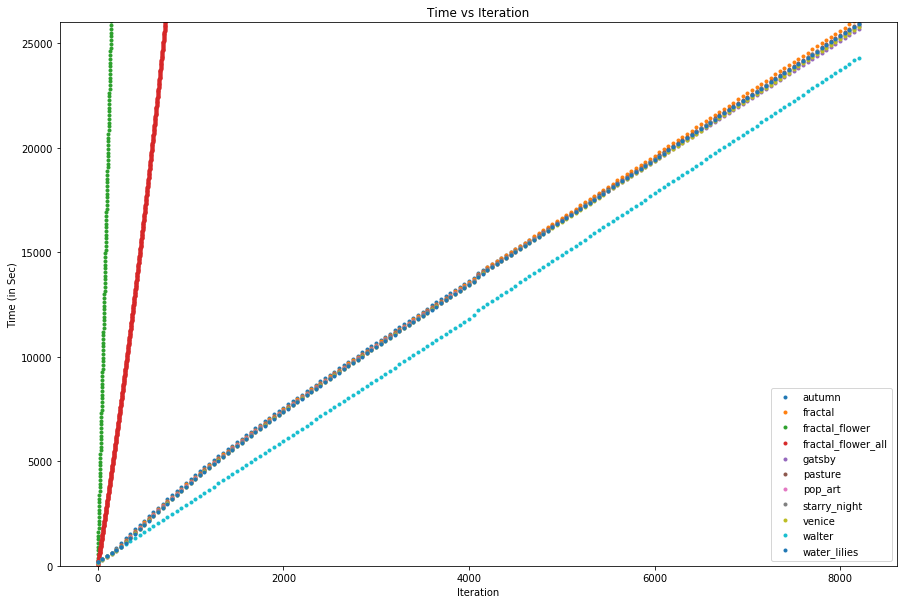

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict
from glob import glob

def get_structured_data(data):
    key_value_tups = (OrderedDict(element.split(' = ') for element in line.split('; ')) for line in data)
    return pd.DataFrame(key_value_tups)

plt.figure(figsize=(15, 10))

for runtime_file in sorted(glob('test_dir_*/runtime_*')):
    with open(runtime_file) as f:
        data = f.read().splitlines()
        useful_data = [line for line in data if 'Current Time' in line]
        structured_data = get_structured_data(useful_data)
        structured_data[['Epoch', 'Iteration']] = structured_data[['Epoch', 'Iteration']].astype('int')
        structured_data[['Loss', 'Time Elapsed']] = structured_data[['Loss', 'Time Elapsed']].astype('float32')
        #structured_data.set_index(structured_data.index * 50, inplace=True) ### hard coded to 50 iterations
        structured_data.set_index(range(len(structured_data)) * structured_data['Iteration'][0], inplace=True) #### seems to work

    structured_data['Time Elapsed'].cumsum().plot(title="Time vs Iteration", 
        marker='o', ms=3, linestyle='None', label=runtime_file.split('/')[0].replace('test_dir_', ''))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Time (in Sec)')
plt.ylim(0, 26000)

In [ ]:
structured_data.scatter

In [ ]:
# Red (32 CPUs) and Green (1 CPU) are noticeably slower. Train for much fewer iterations.
# For CPUs, next time use 10 iterations instead of 1